In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow.keras.backend as K

from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Activation, Add,DepthwiseConv2D, BatchNormalization, Concatenate, Conv2D, Dense,Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Input, Lambda,LeakyReLU, MaxPooling2D, Multiply, Permute, Reshape, UpSampling2D
import collections
import tensorflow as tf
from tensorflow.keras import regularizers
from  tensorflow.keras.initializers import *

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_path = '/content/drive/MyDrive/Published Dataset and Codes/KMC-Grading Work/KMC Grading Dataset/Training/'
test_path = '/content/drive/MyDrive/Published Dataset and Codes/KMC-Grading Work/KMC Grading Dataset/Test'
val_path = '/content/drive/MyDrive/Published Dataset and Codes/KMC-Grading Work/KMC Grading Dataset/Validation'
batch_size = 4
img_height = 224
img_width = 224
no_of_classes = 5
classes_name = [0,1,2,3,4]
input_shape = (img_height , img_width , 3)


random_seed = np.random.seed(1142)

datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    horizontal_flip = False,
    vertical_flip = False,
    #validation_split = 0.1,
    featurewise_std_normalization=True)

train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    class_mode='categorical')

validation_generator = datagen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    class_mode='categorical')


print(train_generator.class_indices)

Found 3432 images belonging to 5 classes.
Found 503 images belonging to 5 classes.
{'grade0': 0, 'grade1': 1, 'grade2': 2, 'grade3': 3, 'grade4': 4}


In [ ]:
def res_block(x,f):
    w,h,c = x.shape[1],x.shape[2],x.shape[3]
    x41 = AveragePooling2D(pool_size = (w,h))(x)
    x41 = Conv2D(f, (1, 1), activation='sigmoid', padding='same')(x41)
    x4 = Multiply()([x,x41])
    return x4

In [ ]:
# def attentionlayer(skip_layer,x0,x1,x2,x3):
#     inter_channel = skip_layer.get_shape().as_list()[3]
#     theta_x0 = Conv2D(inter_channel, [1, 1], strides=[1, 1])(x0)
#     theta_x1 = Conv2D(inter_channel, [1, 1], strides=[1, 1])(x1)
#     theta_x2 = Conv2D(inter_channel, [1, 1], strides=[1, 1])(x2)
#     theta_x3 = Conv2D(inter_channel, [1, 1], strides=[1, 1])(x3)
#     phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1])(skip_layer)
#     added = Activation('relu')(add([theta_x0,theta_x1,theta_x2,theta_x3,phi_g]))
#     psi = Conv2D(1, [1, 1], strides=[1, 1],activation="sigmoid")(added)
#     multiplied = multiply([skip_layer, psi])
#     return multiplied

In [ ]:
# def attentionlayer(skip_layer,x):
#     inter_channel = skip_layer.get_shape().as_list()[3]
#     theta_x0 = Conv2D(inter_channel, [1, 1], strides=[1, 1])(x)
#     phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1])(skip_layer)
#     added = Activation('relu')(add([theta_x0,phi_g]))
#     psi = Conv2D(1, [1, 1], strides=[1, 1],activation="sigmoid")(added)
#     multiplied = multiply([skip_layer, psi])
#     return multiplied

In [ ]:
def conv_layer(x,f):
    conv1 = tf.keras.layers.Conv2D(f, kernel_size=(3, 3), padding='same')(x)
    norm1 = tf.keras.layers.BatchNormalization()(conv1)
    relu1 = tf.keras.layers.Activation('relu')(norm1)
    return relu1

def block(x,y):
    _, width, height, channels = x.shape  # Use .shape instead of .get_shape().as_list()
    group_ch = channels // 2
    x = Reshape([width, height, group_ch, 2])(x)
    x = Permute([1, 2, 4, 3])(x)
    x0 = x[:,:,:,0]
    x1 = x[:,:,:,1]

    _, width, height, channels = y.shape  # Use .shape instead of .get_shape().as_list()
    group_ch = channels // 2
    y = Reshape([width, height, group_ch, 2])(y)
    y = Permute([1, 2, 4, 3])(y)
    y0 = y[:,:,:,0]
    y1 = y[:,:,:,1]

    xy0 = Concatenate()([x0,y1])
    xy1 = Concatenate()([y0,x1])

    xy2 = conv_layer(xy0, channels)
    xy3 = conv_layer(xy1, channels)
    x_o = res_block(xy2, channels)
    y_o = res_block(xy3, channels)
    x_out = Add()([x_o,y_o])
    return x_out

In [ ]:
def resnet_block(block_input, num_filters):

	if tf.keras.backend.int_shape(block_input)[3] != num_filters:
		block_input = tf.keras.layers.Conv2D(num_filters, kernel_size=(1, 1))(block_input)

	conv1 = conv_layer(block_input,num_filters)
	conv2 = block(block_input,conv1)
	sum = Add()([conv2,block_input])
	relu2 = tf.keras.layers.Activation('relu')(sum)
	return relu2

def se_resnet14():

  input = tf.keras.layers.Input(shape=(224, 224, 3))
  conv1 = tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(input)

  block1 = resnet_block(conv1, 16)
  block2 = resnet_block(block1, 16)
 # block3 = resnet_block(block2,16)

  pool1 = tf.keras.layers.MaxPooling2D((2, 2), (2,2))(block2)

  block4 = resnet_block(pool1, 32)
  block5 = resnet_block(block4, 32)
#  block6 = resnet_block(block5,32)

  pool2 = tf.keras.layers.MaxPooling2D((2, 2), (2,2))(block5)

  block7 = resnet_block(pool2, 64)
  block8 = resnet_block(block7, 64)
#  block9 = resnet_block(block8,64)

  global_pool = tf.keras.layers.GlobalAveragePooling2D()(block8)
  x = Dense(128, activation=None)(global_pool)
  x = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.0),gamma_initializer=Constant(1.0),momentum=0.5)(x)
  x = Activation('relu')(x)
  x = Dense(128, activation=None)(x)
  x = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.0),gamma_initializer=Constant(1.0),momentum=0.5)(x)
  x = Activation('relu')(x)
  output = tf.keras.layers.Dense(5, activation='softmax')(x)

  model = tf.keras.models.Model(inputs=input, outputs=output)
  return model


# model_se = se_resnet14()
# model_se.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ["acc"])
# model_se.summary()

In [ ]:
model = se_resnet14()

# for layer in model.layers:
#     if hasattr(layer, 'kernel_regularizer'):
#         layer.kernel_regularizer= regularizers.l2(0.03)

#     if hasattr(layer, 'bias_regularizer'):
#         layer.bias_regularizer= regularizers.l2(0.03)

model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ["acc"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 224, 224, 16)   │            448 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 224, 224, 16)   │          2,320 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 224, 224, 16)   │             64 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 224, 224, 16)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 224, 224, 8, 2) │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 224, 224, 8, 2) │              0 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute (Permute)         │ (None, 224, 224, 2, 8) │              0 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute_1 (Permute)       │ (None, 224, 224, 2, 8) │              0 │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224, 8)    │              0 │ permute[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 224, 224, 8)    │              0 │ permute_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224, 8)    │              0 │ permute_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224, 8)    │              0 │ permute[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 224, 224, 16)   │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_3[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 224, 224, 16)   │              0 │ get_item_2[0][0],      │
│ (Concatenate)             │                        │                │ get_item_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 224, 224, 16)   │          2,320 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 224, 224, 16)   │          2,320 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 345,221 (1.32 MB)

 Trainable params: 343,365 (1.31 MB)

 Non-trainable params: 1,856 (7.25 KB)

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_acc' , mode='max' ,
                                                  factor = 0.5 , patience = 5 , verbose=1 , cooldown = 1,
                                                 min_delta = 0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=40, verbose=1,
                                              mode = 'max', restore_best_weights = True)
check_path = '/content/drive/MyDrive/Published Dataset and Codes/Weight/weight.weights.h5' # Changed the file name to include '.weights.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(check_path, monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')


history_3A3 = model_liver.fit(train_generator,
                             validation_data=validation_generator,
                             steps_per_epoch=len(train_generator),
                             validation_steps=len(validation_generator),
                             epochs=65,
                             callbacks=[reduce_lr, early_stop, checkpoint])


C:\Users\Admin\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
C:\Users\Admin\anaconda3\envs\tf-gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Admin\anaconda3\envs\tf-gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/65
858/858 [==============================] - 110s 104ms/step - loss: 1.4716 - acc: 0.3685 - val_loss: 3.0379 - val_acc: 0.3082

Epoch 00001: val_acc improved from -inf to 0.30815, saving model to E:/Data_2/grading_weights\new_work_222.h5
Epoch 2/65
858/858 [==============================] - 86s 100ms/step - loss: 1.1368 - acc: 0.5437 - val_loss: 9.5987 - val_acc: 0.3360

Epoch 00002: val_acc improved from 0.30815 to 0.33598, saving model to E:/Data_2/grading_weights\new_work_222.h5
Epoch 3/65
858/858 [==============================] - 86s 101ms/step - loss: 0.9988 - acc: 0.6034 - val_loss: 2.3088 - val_acc: 0.4970

Epoch 00003: val_acc improved from 0.33598 to 0.49702, saving model to E:/Data_2/grading_weights\new_work_222.h5
Epoch 4/65
858/858 [==============================] - 87s 101ms/step - loss: 0.8744 - acc: 0.6659 - val_loss: 9.5064 - val_acc: 0.3181

Epoch 00004: val_acc did not improve from 0.49702
Epoch 5/65
858/858 [==============================] - 86s 101ms/step 

In [ ]:
np.save('E:/Data_2/grading_weights/new_work_222.npy',history.history)

In [ ]:
model.load_weights('E:/Data_2/grading_weights/new_work_222.h5')

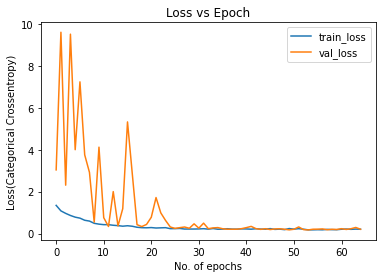

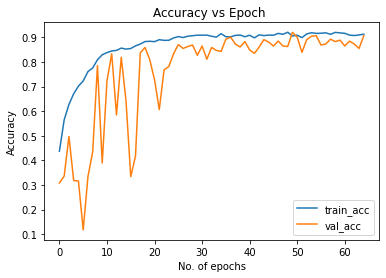

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'] , label = 'train_loss')
plt.plot(history.history['val_loss'] , label = 'val_loss')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Loss(Categorical Crossentropy)")
plt.title("Loss vs Epoch")
# plt.savefig('E:/save-2/R1_loss.png')
plt.show()
#plt.savefig('90.98_loss.png')
plt.plot(history.history['acc'] , label = 'train_acc')
plt.plot(history.history['val_acc'] , label = 'val_acc')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch ")
# plt.savefig('E:/save-2/R1_accuracy.png')
plt.show()

In [ ]:
test_d = ImageDataGenerator(rescale=1. / 255)
test = test_d.flow_from_directory(
    'E:/Data_2/KMC-Kidney-Classification/KMC Dataset for grading/Test/',
    target_size=(224,224),
    batch_size=1,
    shuffle = False,
    class_mode='categorical')

Found 506 images belonging to 5 classes.


In [ ]:
import numpy as np
test_step = test.n//test.batch_size
test.reset()
pred = model.predict_generator(test , steps = test_step , verbose = 1)
pred_class_indices = np.argmax(pred,axis=1)

## printing predicted labels
print(pred_class_indices)

In [ ]:
from sklearn.metrics import *
classes = [0,1,2,3,4]


for cl in classes:

    print("class: ",cl)

    a1 = np.uint8(test.labels == cl)
    a2 = np.uint8(pred_class_indices == cl)

    print('Accuracy {}'.format(accuracy_score(y_true=a1, y_pred=a2)))
    print('F1 {}'.format(f1_score(y_true=a1, y_pred=a2)))
    print('precision {}'.format(precision_score(y_true=a1, y_pred=a2)))
    print('recall {}'.format(recall_score(y_true=a1, y_pred=a2)))

    print('jaccard {}'.format(jaccard_score(y_true=a1, y_pred=a2)))
    print("_______________________________")

class:  0
Accuracy 0.9960474308300395
F1 0.9902912621359222
precision 0.9807692307692307
recall 1.0
jaccard 0.9807692307692307
_______________________________
class:  1
Accuracy 0.9762845849802372
F1 0.9469026548672567
precision 0.8991596638655462
recall 1.0
jaccard 0.8991596638655462
_______________________________
class:  2
Accuracy 0.9446640316205533
F1 0.8333333333333333
precision 0.9722222222222222
recall 0.7291666666666666
jaccard 0.7142857142857143
_______________________________
class:  3
Accuracy 0.9525691699604744
F1 0.8947368421052632
precision 0.8292682926829268
recall 0.9714285714285714
jaccard 0.8095238095238095
_______________________________
class:  4
Accuracy 0.9802371541501976
F1 0.9456521739130435
precision 0.9886363636363636
recall 0.90625
jaccard 0.8969072164948454
_______________________________


In [ ]:
print('Accuracy {}'.format(accuracy_score(y_true=test.labels, y_pred=pred_class_indices)))
print('F1 {}'.format(f1_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('precision {}'.format(precision_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('recall {}'.format(recall_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))

print('jaccard {}'.format(jaccard_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('confusion_matrix\n {}'.format(confusion_matrix(y_true=test.labels, y_pred=pred_class_indices)))
print('classification_report\n {}'.format(classification_report(y_true=test.labels, y_pred=pred_class_indices)))
print('\n\n')

Accuracy 0.924901185770751
F1 0.9221832532709637
precision 0.934011154635258
recall 0.9213690476190475
jaccard 0.8601291269878294
confusion_matrix
 [[102   0   0   0   0]
 [  0 107   0   0   0]
 [  2  12  70  12   0]
 [  0   0   2 102   1]
 [  0   0   0   9  87]]
classification_report
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       102
           1       0.90      1.00      0.95       107
           2       0.97      0.73      0.83        96
           3       0.83      0.97      0.89       105
           4       0.99      0.91      0.95        96

    accuracy                           0.92       506
   macro avg       0.93      0.92      0.92       506
weighted avg       0.93      0.92      0.92       506




